## Project.8 Машинное обучение. Сборный проект. Добыча золота

    (yandex_practicum by student@pavel_matushevskiy, Volgograd 2022)

### Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

### Описание данных

Данные находятся в трёх файлах:  

•	gold_recovery_train_new.csv — обучающая выборка;  

•	gold_recovery_test_new.csv — тестовая выборка;  

•	gold_recovery_full_new.csv — исходные данные.


### Наименование признаков

[этап].[тип_параметра].[название_параметра]  

Пример: rougher.input.feed_ag  

Возможные значения для блока [этап]:  

rougher — флотация  

primary_cleaner — первичная очистка  

secondary_cleaner — вторичная очистка  

final — финальные характеристики  

Возможные значения для блока [тип_параметра]:  

input — параметры сырья  

output — параметры продукта  

state — параметры, характеризующие текущее состояние этапа  

calculation — расчётные характеристики


### Параметры этапов

air amount — объём воздуха  

fluid levels — уровень жидкости  

feed size — размер гранул сырья  

feed rate — скорость подачи

### Инструкция по выполнению проекта:
1. Подготовьте данные  

1.1. Откройте файлы и изучите их.  

1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery.   
Найдите MAE между вашими расчётами и значением признака. Опишите выводы.  

1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?  

1.4. Проведите предобработку данных.  

2. Проанализируйте данные  

2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.  

2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.  

2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.  

3. Постройте модель  

3.1. Напишите функцию для вычисления итоговой sMAPE.  

3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.  



### 1. Подготовка библиотек и данных

In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

RANDOM_STATE = 42

In [2]:
# расширение ноутбука на ширину всего экрана
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
# приятная темная тема оформления для графиков
from jupyterthemes import jtplot
jtplot.style()

### Шаг 1.1. Загрузка данных и общий обзор.

In [6]:
# Подгрузим наши файлы:
try:
    train_data = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    test_data = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    full_data = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    train_data = pd.read_csv('datasets/gold_recovery_train_new.csv')
    test_data = pd.read_csv('datasets/gold_recovery_test_new.csv')
    full_data = pd.read_csv('datasets/gold_recovery_full_new.csv')

In [7]:
# Посмотрим на данные во всех датасетах:
train_data.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [10]:
test_data.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [11]:
full_data.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [12]:
# Посмотрим сводную информацию по всем датасетам:
for df in (train_data, test_data, full_data):
    print(df.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [13]:
# немного статистики по признакам на базе full_data датасета:
full_data.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


<AxesSubplot:>

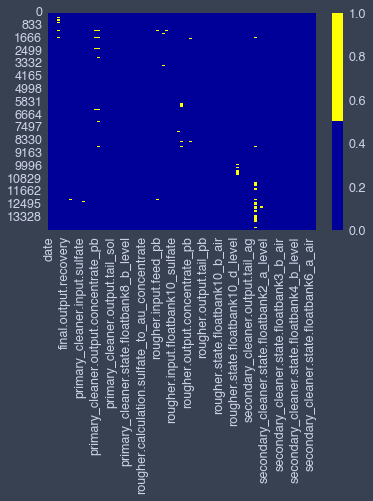

In [15]:
# визуализируем пропуски в train_data чтобы было более наглядно:
colours = ['#000099', '#ffff00']
cols = df.columns[:90]
sns.heatmap(train_data[cols].isnull(), cmap=sns.color_palette(colours))

### Промежуточный вывод

1. Во всех 3 датасетах имеем дело с числовыми признаками. Обучающий датасет содержит итоговые рассчитанные параметры (признаки), которых нет в тестов датасете. Все эти признаки нужно будет убрать из обучающей выборки, т.к. прогнозировать по этим данным не получится.
2. В данных имеются пропуски, их нужно обработать.

In [12]:
# Для проверки эффективности обогащения напишем функцию:
def recovery(C, F, T):
    return ((C * (F - T)) / (F * (C - T))) * 100


def calculate_recovery_data(df):
    C = df['rougher.output.concentrate_au']
    F = df['rougher.input.feed_au']
    T = df['rougher.output.tail_au']

    return recovery(C, F, T)

In [13]:
# Оставим только те признаки, которые нужны для рассчетов и сравнений
columns = [
    'rougher.output.concentrate_au', 'rougher.input.feed_au',
    'rougher.output.tail_au', 'rougher.output.recovery'
]
train_data_check = train_data[columns]
train_data_check = train_data_check.dropna()
train_data_check.isnull().sum()

rougher.output.concentrate_au    0
rougher.input.feed_au            0
rougher.output.tail_au           0
rougher.output.recovery          0
dtype: int64

In [14]:
train_data_check[
    'rougher.output.recovery_calculated'] = train_data_check.apply(
        calculate_recovery_data, axis=1)
# проведем рассчеты проверки разницы эффективности обогащения с данными из датасета:
mae_metric = mean_absolute_error(
    train_data_check['rougher.output.recovery'],
    train_data_check['rougher.output.recovery_calculated'])
mae_metric

9.73512347450521e-15

### Промежуточный вывод
1. Метрика MAE получилась низкой, значит будем считать, что эффективность обогащения рассчитана верно.
2. Для лучших результатов как выяснилось, эффективнее удалить пропущенные данные.

### 1.3 Анализ признаков, недоступных в тестовой выборке. 

In [15]:
# Посмотрим, какие признаки есть в обучающей выборке, но отсутствуют в тестовой:
columns_data_diff = set(train_data.columns) - set(test_data.columns)
print("кол-во отсутствующих признаков:", len(columns_data_diff))
columns_data_diff

кол-во отсутствующих признаков: 34


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

### Промежуточные вывод

Данные признаки либо вычисляемы, либо являются итоговым результатом прохождения этапов. А значит мы не можем корректно на них учиться, т.к. они могут быть банально неизвестны на начало предсказаний. Мы можем оперировать только теми параметрами, на значения которых можем прозрачно влиять

In [16]:
# Чтобы однозначно связать данные всех выборок, зададим уже имеющимся датафреймам в качестве индекса дату
train_data = train_data.set_index('date')
test_data = test_data.set_index('date')
full_data = full_data.set_index('date')

In [17]:
# Для начала оставим в обучающей выборке только те признаки, что есть в тестов датасете:
train_data_selected = train_data[test_data.columns]

#### Обработка пропусков в данных:¶

In [18]:
train_data.isnull().sum()

final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
final.output.recovery                           0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 86, dtype: int64

In [19]:
full_data.isnull().sum()

final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
final.output.recovery                           0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 86, dtype: int64

In [20]:
test_data.isnull().sum()

primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatbank10_xanthate             0
rougher.input.floatb

В данных имеются пропуски.

При этом по условиям самой задачи, данные соседних измерений часто похожи, поэтому  поступим следующим образом:   
создадим для проекта 2 датасета для обучения модели:   

train_data_selected_drop - в нем пропуски удалим,   

train_data_selected_fill  - в другом заполним с помощью fillna - ffill (заполнение следующим известным значением), т.к. медиана и среднее для заполнения пропусков нам не подойдут по условиям задачи.    


В дальнейшем  выберем наилучший датасет для модели.

In [21]:
train_data_selected_fill = train_data_selected.fillna(method='ffill')
train_data_selected_drop = train_data_selected.dropna()

# повторим алгоритмы обработки пропусков и для итоговой выборки:
full_data_fill = full_data.fillna(method='ffill')
full_data_drop = full_data.dropna()

test_data_fill = test_data.fillna(method='ffill')  # это надо???
test_data_drop = test_data.dropna()

In [22]:
# На всякий случай проверим дубликаты
print(train_data_selected_drop.duplicated().sum())
train_data_selected_fill.duplicated().sum()

0


0

In [23]:
# вариант 1 (с удалением пропусков): в итоге - это лучший вариант по результатам метрики SMAPE!
train_data_selected_x =  copy.copy(train_data_selected_drop)
full_data_x1 = copy.copy(full_data_drop)
test_data_x1 = copy.copy(test_data_drop)

In [24]:
# вариант 2 (с заполнением пропусков): 
train_data_selected_x = copy.copy(train_data_selected_fill)
full_data_x = copy.copy(full_data_fill)
test_data_x = copy.copy(test_data_fill)

### Вывод шага:

1. Мы изучили данные, проверили корректность рассчета эффективности обогащения
2. Оставили в обучающей выборке только те значения, на которых мы можем обучать модель в дальнейшем
Все выборки мы связали через индекс по датам
3. Мы провели небольшую предобработку наших данных и готовы к дальнейшему анализу (при этом держим в голове пока наличие нулевых значений)
4.Также пока мы работаем со всеми признаками и оставили две выборки (с заполненными и дропнутыми пропусками), что может быть полезным для дальнейшего анализа.

### 2. Анализ данных. EDA

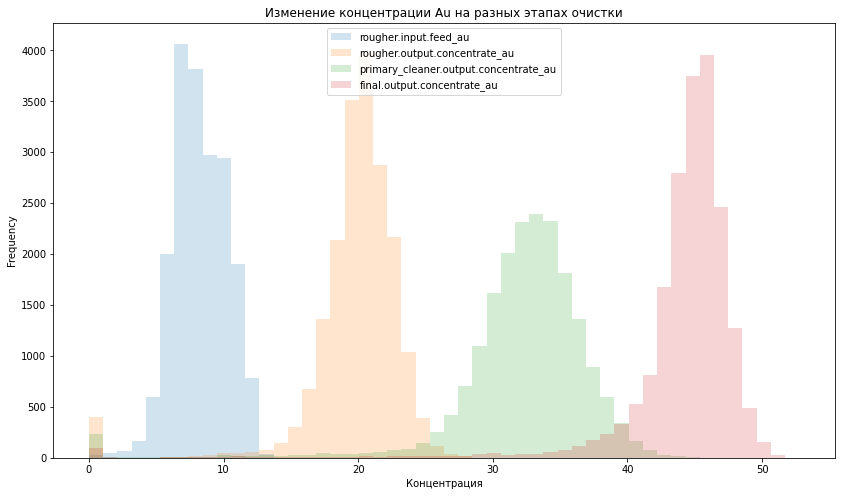

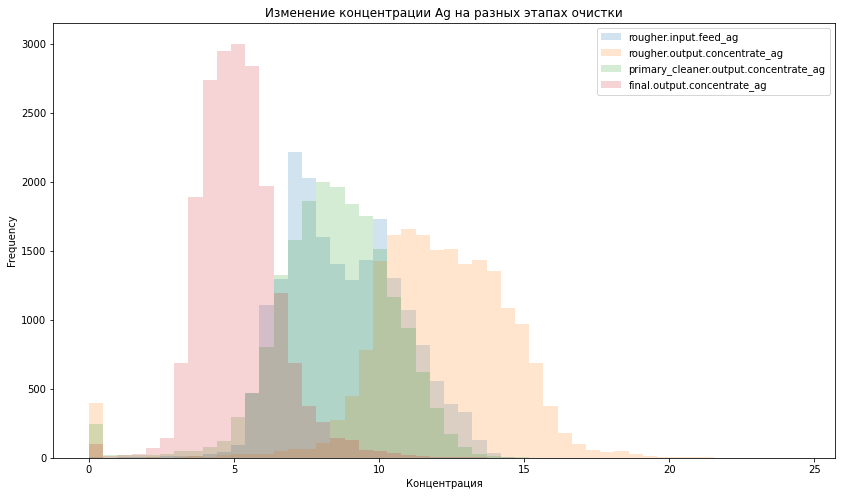

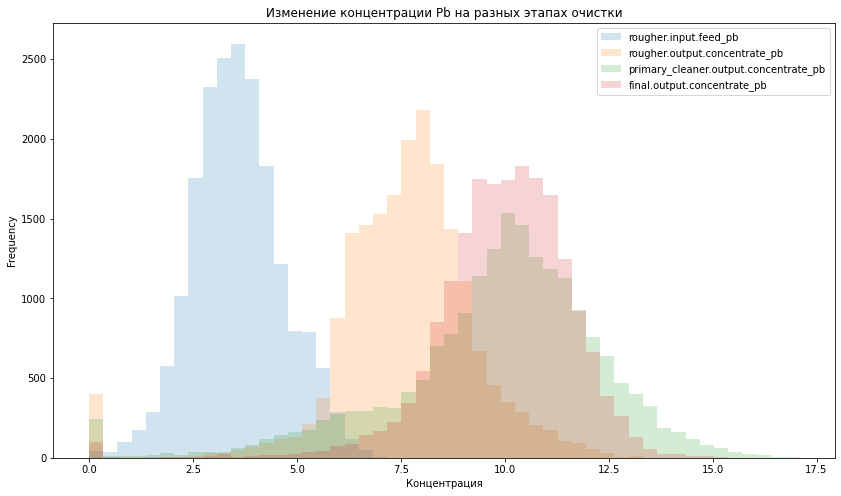

In [25]:
# Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки
# Чтобы быть более точными, будем смотреть на полном наборе данных со сброшенными пустыми значениями
au_list = [
    'rougher.input.feed_au', 'rougher.output.concentrate_au',
    'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'
]
ag_list = [
    'rougher.input.feed_ag', 'rougher.output.concentrate_ag',
    'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'
]
pb_list = [
    'rougher.input.feed_pb', 'rougher.output.concentrate_pb',
    'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'
]

metall_dict = {"Au": au_list, "Ag": ag_list, "Pb": pb_list}
for key in metall_dict:
    title = 'Изменение концентрации ' + key + ' на разных этапах очистки'

    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('Концентрация')

    full_data_x[metall_dict[key]].plot(kind='hist',
                                       bins=50,
                                       figsize=(14, 8),
                                       ax=ax,
                                       legend=True,
                                       alpha=0.2)

## Промежуточный вывод

1. Концентрация золота с каждым этапом растет. При чем на первичной очистке распределение охватывает более широкий диапазон.
2. Концентрация серебра напротив убывает с каждым этапом
3. Концентрация свинца также растет вместе с золотом, при чем после первичной очистки его не становится сильно меньше (уменьшается только разброс)
4. Во всех случаях есть непонятные пики с нулевыми и околонулевыми значениями, которые уменьшаются к финальному этапу

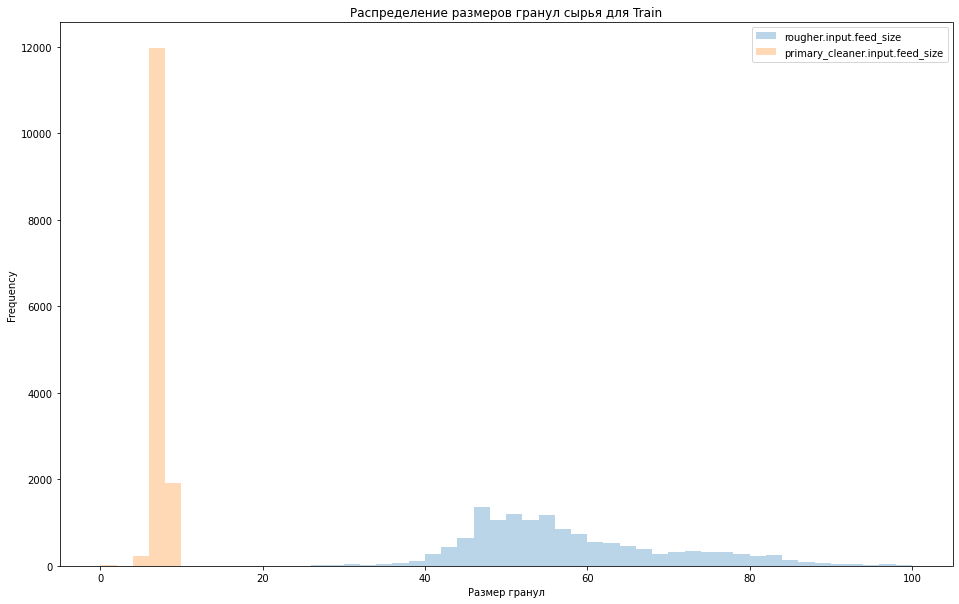

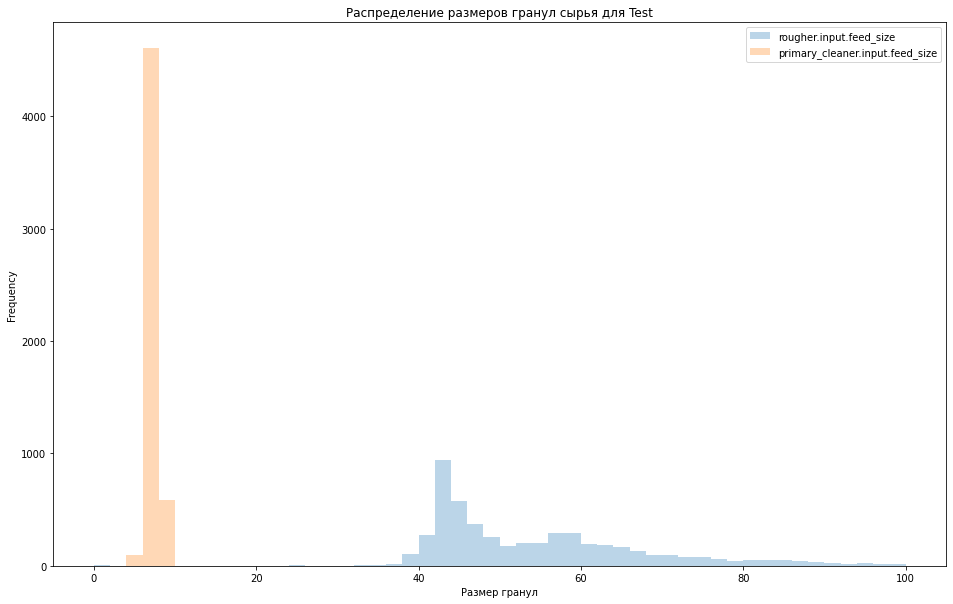

In [26]:
# Сравним распредление размеров гранул сырья

df_dict = {"Train": train_data_selected_x, "Test": test_data_x}
feed_size_fields = [
    'rougher.input.feed_size', 'primary_cleaner.input.feed_size'
]

for key in df_dict:
    df = df_dict[key]
    title = 'Распределение размеров гранул сырья для ' + key

    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('Размер гранул')

    df[feed_size_fields].plot(kind='hist',
                              bins=50,
                              range=(0, 100),
                              figsize=(16, 10),
                              ax=ax,
                              legend=True,
                              alpha=0.3)

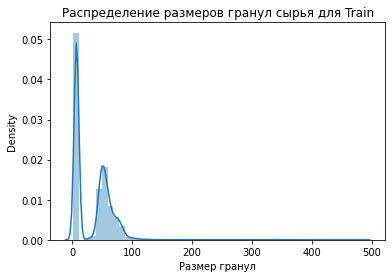

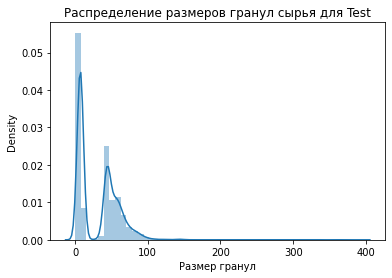

In [27]:
# Сравним распредление размеров гранул сырья

df_dict = {"Train": train_data_selected_x, "Test": test_data_x}
feed_size_fields = [
    'rougher.input.feed_size', 'primary_cleaner.input.feed_size'
]

for key in df_dict:
    df = df_dict[key]
    title = 'Распределение размеров гранул сырья для ' + key

    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('Размер гранул')

    sns.distplot(df[feed_size_fields], kde=True, bins=50, ax=ax)

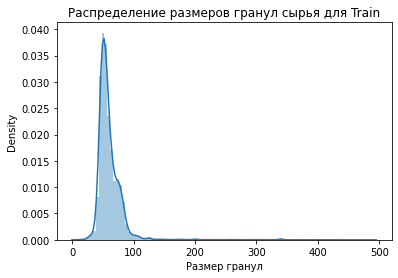

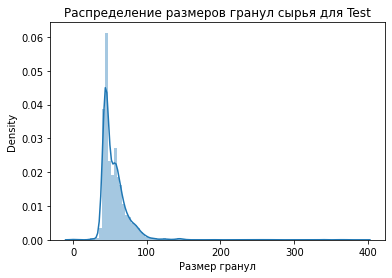

In [28]:
# Сравним распредление размеров гранул сырья

df_dict = {"Train": train_data_selected_x, "Test": test_data_x}
feed_size_fields = [
    'rougher.input.feed_size'  # 'primary_cleaner.input.feed_size'
]

for key in df_dict:
    df = df_dict[key]
    title = 'Распределение размеров гранул сырья для ' + key

    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('Размер гранул')

    sns.distplot(df[feed_size_fields], kde=True, bins=100, ax=ax)

### Промежуточный вывод

Распределения размеров гранул на обучающей и тестовой выборке сопоставимы, похожи на колокол (что говорит о нормальном распределении).  

<div class="alert alert-info"> <b> Комментарий студента #3:</b> Внес правки. </div>

In [29]:
full_data_fill.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

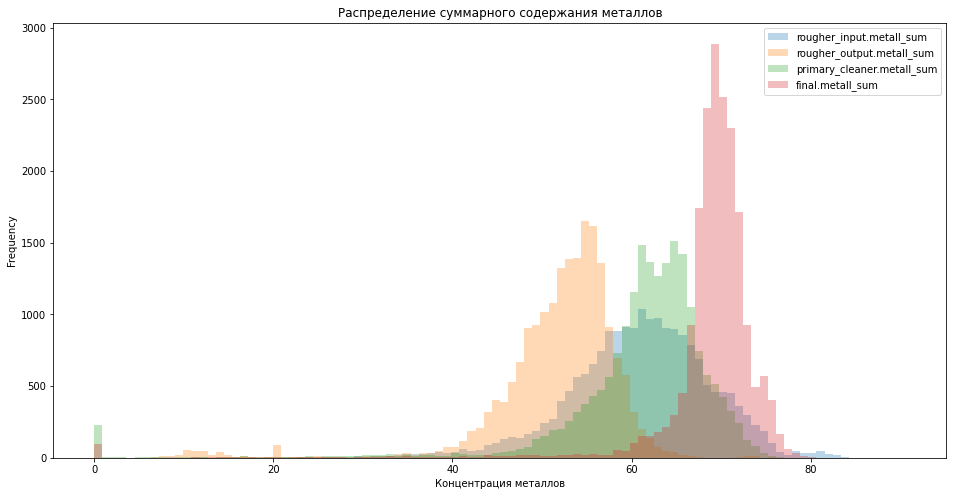

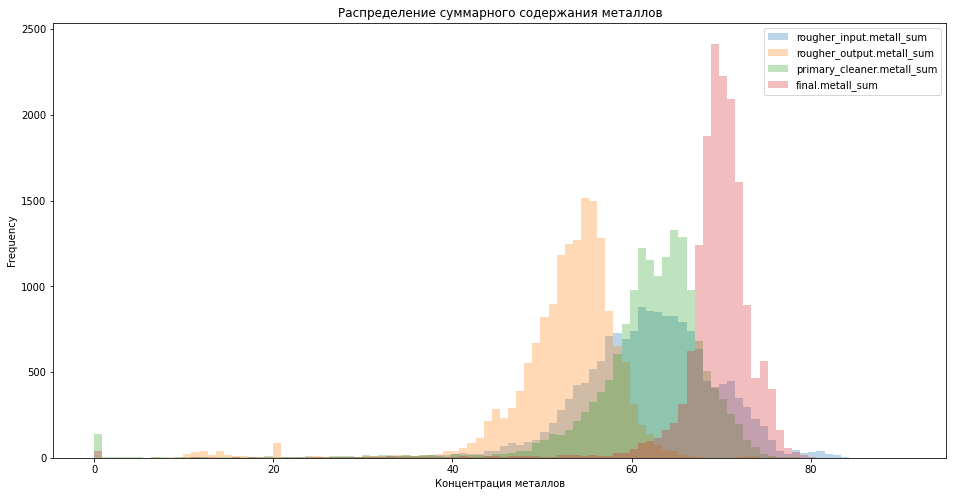

In [30]:
# Исследуем суммарную концентрацию всех веществ на разных стадиях на full_data_fill, full_data_drop
df_list = [full_data_fill, full_data_drop]
sum_fields = [
    'rougher_input.metall_sum',  'rougher_output.metall_sum','primary_cleaner.metall_sum', 'final.metall_sum'
]

for df in df_list:
    df['rougher_input.metall_sum'] = df['rougher.input.feed_pb'] + df[
      'rougher.input.feed_sol'] + df[ 'rougher.input.feed_au'] + df['rougher.input.floatbank10_sulfate']
    
    df['rougher_output.metall_sum'] = df['rougher.output.concentrate_ag'] + df[
        'rougher.output.concentrate_au'] + df['rougher.output.concentrate_pb'] + df['rougher.input.floatbank10_sulfate']
    df['primary_cleaner.metall_sum'] = df[
        'primary_cleaner.output.concentrate_ag'] + df[
            'primary_cleaner.output.concentrate_au'] + df[
                'primary_cleaner.output.concentrate_pb'] + df[
                'primary_cleaner.output.concentrate_sol']
    df['final.metall_sum'] = df['final.output.concentrate_ag'] + df[
        'final.output.concentrate_au'] + df['final.output.concentrate_pb'] + df['final.output.concentrate_sol']

    fig, ax = plt.subplots()
    ax.set_title('Распределение суммарного содержания металлов')
    ax.set_xlabel('Концентрация металлов')
    df[sum_fields].plot(kind='hist',
                        bins=100,
                        figsize=(16, 8),
                        ax=ax,
                        legend=True,
                        alpha=0.3)
    plt.show()

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
Предупреждения можно отключить, добавив в ячейку с импортами:
```python
import warnings
warnings.filterwarnings('ignore')
``` 


<div class="alert alert-info"> <b> Комментарий студента #4:</b> Спасибо за совет. </div>

### Промежуточный вывод

1. Отчетливо видны пики на нулевых значениях, а это означает, что каждое слагаемое в замере равно нулю, из чего можно сделать вывод, что это аномалия, а не норма и такие значения стоит удалить из всех выборок.
2. Также, в целом низкая суммарная концентрация встречается крайне редко, поэтому такие значения нам также вряд ли помогут.
3. Отчетливо видно, что количество аномалий кратно возрастает в выборке, где мы не удаляли пустые значения. А значит все же большинство пустых значений могли означать, что концентрацию получить не удалось и она крайне мала

<div class="alert alert-info"> <b> Комментарий студента #5:</b> Исправил. </div>

### Обработка аномалий

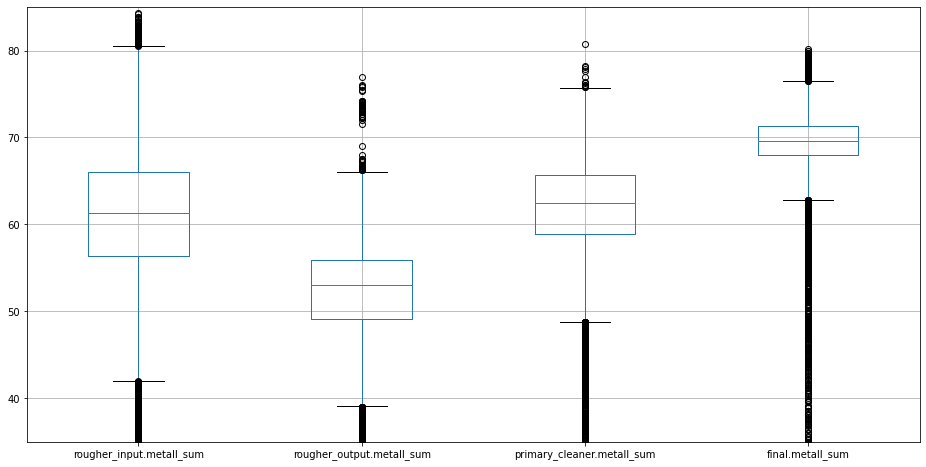

In [31]:
# Обработаем аномалии, для начала посмотрим boxplot
full_data_x = copy.copy(full_data_fill)
full_data_x.boxplot(column=[ 'rougher_input.metall_sum','rougher_output.metall_sum', 'primary_cleaner.metall_sum', 'final.metall_sum'], figsize=(16, 8))
plt.ylim(35,85)
plt.show()

 <br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера  <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>

</b> Ячейка выше не отработала. Перед отправкой проекта стоит проверять работоспособность кода - это можно сделать, нажав на панели Jupiter Hub `Kernel` и `Restart & Run All`. Исправь, пожалуйста.

<div class="alert alert-info"> <b> Комментарий студента #6:</b> Исправил. </div>

In [32]:
len(full_data_x)

19439

In [33]:
# Вариант#1:
# Удалим выбросы c заменой выбросов на макс и мин значения по границам перцентилей:
full_data_x1 = full_data_x.copy()
for df in [full_data_x1]:
    for x in [
            'rougher_input.metall_sum', 'rougher_output.metall_sum',
            'primary_cleaner.metall_sum', 'final.metall_sum'
    ]:
        q75, q25 = np.percentile(df.loc[:, x], [75, 25])
        intr_qr = q75 - q25

        max = q75 + (1.5 * intr_qr)
        min = q25 - (1.5 * intr_qr)

        df.loc[df[x] < min, x] = min
        #df.loc[df[x] < min,x] = np.nan #просто удаление выбросов  так значение SMAPE выше/ниже (посчитать?)
        df.loc[df[x] > max, x] = max
        #df.loc[df[x] > min,x] = np.nan #просто удаление выбросов

# посмотрим насколько все изменилось
print(len(full_data_x))
print("кол-во удаленных строк:", len(full_data_fill) - len(full_data_x))

19439
кол-во удаленных строк: 0


In [34]:
# Вариант#2:
# Удалим выбросы c заменой выбросов на макс и мин значения по границам перцентилей:
# удаляем выбросы - значение SMAPE лучше!
for df in [full_data_x]:
    for x in [
        'rougher_input.metall_sum', 'rougher_output.metall_sum',
            'primary_cleaner.metall_sum', 'final.metall_sum'
    ]:
        q75, q25 = np.percentile(df.loc[:, x], [75, 25])
        intr_qr = q75 - q25

        max = q75 + (1.5 * intr_qr)
        min = q25 - (1.5 * intr_qr)

        #df.loc[df[x] < min, x] = min
        df.loc[
            df[x] < min,
            x] = np.nan  # просто удаление выбросов  так значение SMAPE ниже (т.е. лучше)
        #df.loc[df[x] > max, x] = max
        df.loc[df[x] > max, x] = np.nan  # просто удаление выбросов

# посмотрим насколько все изменилось
full_data_x = full_data_x.dropna()
print(len(full_data_x))
print("кол-во удаленных строк:", len(full_data_fill) - len(full_data_x))

16574
кол-во удаленных строк: 2865


In [35]:
full_data_x.isnull().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank6_a_level    0
rougher_input.metall_sum                      0
rougher_output.metall_sum                     0
primary_cleaner.metall_sum                    0
final.metall_sum                              0
Length: 90, dtype: int64

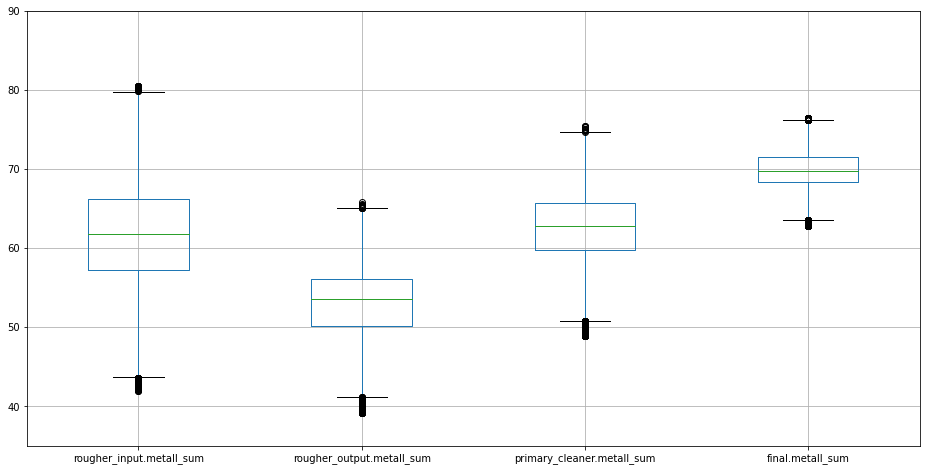

In [36]:
# посмотрим теперь на результат обработки аномалий:
full_data_x.boxplot(column=[
    'rougher_input.metall_sum', 'rougher_output.metall_sum',
    'primary_cleaner.metall_sum', 'final.metall_sum'
],
    figsize=(16, 8))
plt.ylim(35, 90)
plt.show()

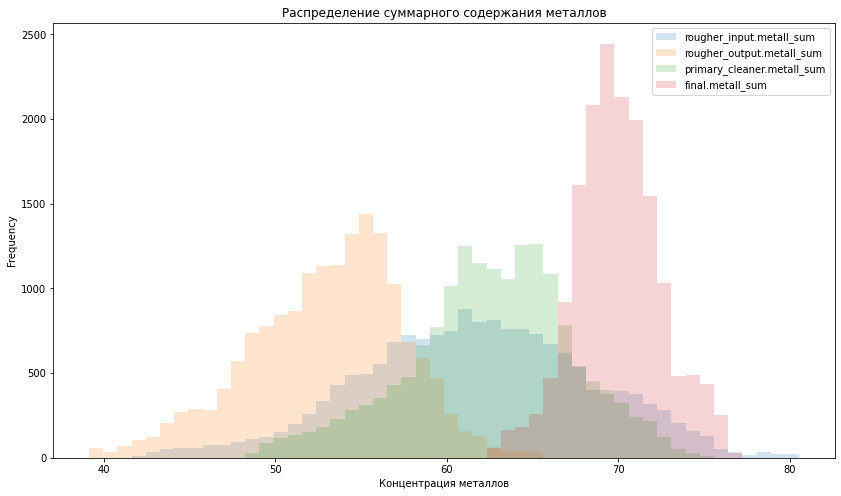

In [37]:
# Посмотрим график
fig, ax = plt.subplots()
ax.set_title('Распределение суммарного содержания металлов')
ax.set_xlabel('Концентрация металлов')
full_data_x[sum_fields].plot(kind='hist',
                             bins=50,
                             figsize=(14, 8),
                             ax=ax,
                             legend=True,
                             alpha=0.2)
plt.show()

In [38]:
# Уберем аномалии из обучающий и тестовой выборок:
train_data_selected_x = train_data_selected_x[train_data_selected_x.index.isin(
    full_data_x.index)]
test_data = test_data[test_data.index.isin(full_data_x.index)]
# дропнем пропуски из тестового датасета:
test_data = test_data.dropna()
# посчитаем, сколько у нас осталось данных в train_data для обучения:
len(train_data_selected_x)

11942

### Вывод шага:

1. Мы проанализировали наши данные и посмотрели как менятся концентрации металов на различных этапах очистки (золото и свинец растет, а серебро падает)
2. Визуально оценили распределение размеров гранул в обучающей и тестовой выборке
3. Исследовали суммарную концентрацию веществ на разных стадиях
4. Удалили аномалии из данных наиболее результативным способом (сравнили результаты метрик на выходе).

### Шаг 3. Построение модели.

In [39]:
# нам нужны предсказания rougher.output.recovery и final.output.recovery, но в трейне их нет
# исправим это: извлекем эти данные из full_data:
target_data = full_data_x[full_data_x.index.isin(
    train_data_selected_x.index)][[
        'rougher.output.recovery', 'final.output.recovery'
    ]]
target_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11942 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rougher.output.recovery  11942 non-null  float64
 1   final.output.recovery    11942 non-null  float64
dtypes: float64(2)
memory usage: 279.9+ KB


In [40]:
# Аналогично получим таргет для теста
test_data_target = full_data_x[full_data_x.index.isin(
    test_data.index)][['rougher.output.recovery', 'final.output.recovery']]
test_data_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4600 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rougher.output.recovery  4600 non-null   float64
 1   final.output.recovery    4600 non-null   float64
dtypes: float64(2)
memory usage: 107.8+ KB


 По сути в нашем случае необходимо два признака, однако учить их на одинаковых параметрах не имеет смысла. 
 Во-первых, на результат флотации не могут влиять значения "из будущего" в виде первичной очистки
 Во-вторых, для финального результата нет смысла опираться на флотацию (ее результаты пошли как раз в первую очистку)
 Исходя из этого, нам понадобятся две разные модели и у них будут разные итоговые наборы признаков в рамках train выборки



In [41]:
rougher_level_columns = [
    'rougher.input.feed_ag', 'rougher.input.feed_pb',
    'rougher.input.feed_rate', 'rougher.input.feed_size',
    'rougher.input.feed_sol', 'rougher.input.feed_au',
    'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level'
]

# Тут по сути правильно смотреть только на результат второй очистки, т.к. результат первой дает как раз её
# Но входные параметры определяются также на первичной очистке, поэтому добавим также и их
final_level_columns = [
    'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
    'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
    'primary_cleaner.state.floatbank8_a_air',
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_b_air',
    'primary_cleaner.state.floatbank8_b_level',
    'primary_cleaner.state.floatbank8_c_air',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_d_air',
    'primary_cleaner.state.floatbank8_d_level',
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_a_level',
    'secondary_cleaner.state.floatbank2_b_air',
    'secondary_cleaner.state.floatbank2_b_level',
    'secondary_cleaner.state.floatbank3_a_air',
    'secondary_cleaner.state.floatbank3_a_level',
    'secondary_cleaner.state.floatbank3_b_air',
    'secondary_cleaner.state.floatbank3_b_level',
    'secondary_cleaner.state.floatbank4_a_air',
    'secondary_cleaner.state.floatbank4_a_level',
    'secondary_cleaner.state.floatbank4_b_air',
    'secondary_cleaner.state.floatbank4_b_level',
    'secondary_cleaner.state.floatbank5_a_air',
    'secondary_cleaner.state.floatbank5_a_level',
    'secondary_cleaner.state.floatbank5_b_air',
    'secondary_cleaner.state.floatbank5_b_level',
    'secondary_cleaner.state.floatbank6_a_air',
    'secondary_cleaner.state.floatbank6_a_level'
]

df_rougher_train = train_data_selected_x[rougher_level_columns]
df_rougher_target = target_data['rougher.output.recovery']

df_final_train = train_data_selected_x[final_level_columns]
df_final_target = target_data['final.output.recovery']

df_rougher_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11942 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_ag               11942 non-null  float64
 1   rougher.input.feed_pb               11942 non-null  float64
 2   rougher.input.feed_rate             11942 non-null  float64
 3   rougher.input.feed_size             11942 non-null  float64
 4   rougher.input.feed_sol              11942 non-null  float64
 5   rougher.input.feed_au               11942 non-null  float64
 6   rougher.input.floatbank10_sulfate   11942 non-null  float64
 7   rougher.input.floatbank10_xanthate  11942 non-null  float64
 8   rougher.input.floatbank11_sulfate   11942 non-null  float64
 9   rougher.input.floatbank11_xanthate  11942 non-null  float64
 10  rougher.state.floatbank10_a_air     11942 non-null  float64
 11  rougher.state.

In [42]:
df_final_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11942 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               11942 non-null  float64
 1   primary_cleaner.input.depressant            11942 non-null  float64
 2   primary_cleaner.input.feed_size             11942 non-null  float64
 3   primary_cleaner.input.xanthate              11942 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      11942 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    11942 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      11942 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    11942 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      11942 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    11942 non-nu

Поскольку у нас числовые данные в признаках разного масштаба, обработаем их (стандартизируем значения данных) для облегчения работы модели:

In [43]:
#pd.set_option('mode.chained_assignment', None)
rougher_scaler = StandardScaler()
rougher_scaler.fit(df_rougher_train[rougher_level_columns])
df_rougher_train[rougher_level_columns] = rougher_scaler.transform(
    df_rougher_train[rougher_level_columns])

final_scaler = StandardScaler()
final_scaler.fit(df_final_train[final_level_columns])
df_final_train[final_level_columns] = final_scaler.transform(
    df_final_train[final_level_columns])

# то же самое сделаем и с данными test_data:
test_data[rougher_level_columns] = rougher_scaler.transform(
    test_data[rougher_level_columns])
test_data[final_level_columns] = final_scaler.transform(
    test_data[final_level_columns])

#### Функция для вычисления итоговой sMAPE

In [44]:
# Напишем функцию для вычисления итоговой sMAPE
def smape_metric(target, predicted):
    result = 0
    for key in range(0, len(predicted)):
        result += abs(target[key] - predicted[key]) / (
            (abs(target[key]) + abs(predicted[key])) / 2)
    result = (result / len(predicted)) * 100

    return result


def calculate_smape(target_rougher, predicted_rougher, target_final,
                    predicted_final):
    return 0.25 * smape_metric(target_rougher,
                               predicted_rougher) + 0.75 * smape_metric(
                                   target_final, predicted_final)

Обучим несколько моделей для сравнения результатов и выберем лучшую.

#### 3.1. Модель случайный лес

In [45]:
my_scorer = make_scorer(smape_metric, greater_is_better=False)

In [46]:
%%time
# Обучим случайный лес, 
# оценивать будем на флотации

parameters = {
    'n_estimators': range(20, 40, 5), #50
    'max_depth': range(6, 12, 2), #(6, 12, 2),
    'min_samples_leaf': range(3, 10) #10
   }

model = RandomForestRegressor()

grid = GridSearchCV(model, parameters, cv=10, scoring=my_scorer, n_jobs=-1)
grid.fit(df_rougher_train, df_rougher_target)
print(grid.best_params_)
print(print("SMAPE metric:", grid.best_score_))

{'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 20}
SMAPE metric: -5.695118932493256
None
CPU times: user 36min 58s, sys: 3.74 s, total: 37min 2s
Wall time: 40min 28s


In [47]:
%%time
# Обучим случайный лес, №2
# оценивать будем на финальном этапе


parameters = {
    'n_estimators': range(20, 30, 5), #50
    'max_depth': range(6, 12, 2), #(6, 12, 2),
    'min_samples_leaf': range(5, 10) #10
   }

model = RandomForestRegressor()

grid = GridSearchCV(model, parameters, cv=10, scoring=my_scorer, n_jobs=-1)
grid.fit(df_final_train, df_final_target)
print(grid.best_params_)
print(print("SMAPE metric:", grid.best_score_))

{'max_depth': 8, 'min_samples_leaf': 8, 'n_estimators': 25}
SMAPE metric: -8.90651711357977
None
CPU times: user 14min 26s, sys: 963 ms, total: 14min 27s
Wall time: 19min 13s


In [48]:
# Посмотрим скоринг при лучших параметрах леса на флотации стадии:
model_forest = RandomForestRegressor(n_estimators=25,
                                     max_depth=8,
                                     min_samples_leaf=9, n_jobs=-1,
                                     random_state=RANDOM_STATE)

# Оценим модель кросс-валидацией
scores = cross_val_score(model_forest,
                         df_rougher_train,
                         df_rougher_target,
                         cv=50,
                         scoring=my_scorer)
mean_score = abs(sum(scores) / len(scores))
print("SMAPE metric for RandomForestRegressor flotation stage:", mean_score)

SMAPE metric for RandomForestRegressor flotation stage: 4.604771419878258


In [49]:
# Посмотрим скоринг при лучших параметрах леса на финальной стадии:
model_forest = RandomForestRegressor(n_estimators=25,
                                     max_depth=8,
                                     min_samples_leaf=9, n_jobs=-1,
                                     random_state=RANDOM_STATE)

# Оценим модель кросс-валидацией
scores = cross_val_score(model_forest,
                         df_final_train, df_final_target,
                         cv=50,
                         scoring=my_scorer)
mean_score = abs(sum(scores) / len(scores))
print("SMAPE metric for RandomForestRegressor final stage:", mean_score)

SMAPE metric for RandomForestRegressor final stage: 7.928786385621057


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
     
Если используешь `GridSearchCV`, то нет смысла дополнительно считать с `cross_val_score`. Кросс-валидация уже встроена в `GridSearchCV`. Если мы используем `GridSearchCV`, то лучшую усредненную метрику можно вызвать  с помощью атрибута `.best_score_`.

#### 3.2. Модель линейная регрессия

In [50]:
# Оценим линейную регрессию на флотации с помощью кросс-валидации
model_lr = LinearRegression()
scores = cross_val_score(model_lr,
                         df_rougher_train,
                         df_rougher_target,
                         cv=50,  n_jobs=1,
                         scoring=my_scorer)
mean_score = abs(sum(scores) / len(scores))
print("SMAPE metric for LR flotation stage:", mean_score)

SMAPE metric for LR flotation stage: 5.175075065763657


In [51]:
# Оценим линейную регрессию на финальном этапе с помощью кросс-валидации
model_lr = LinearRegression()
scores = cross_val_score(model_lr,
                         df_final_train, df_final_target,
                         cv=50,  n_jobs=1,
                         scoring=my_scorer)
mean_score = abs(sum(scores) / len(scores))
print("SMAPE metric for LR final stage:", mean_score)

SMAPE metric for LR final stage: 8.109525283042359


#### CatBoostRegressor model

In [52]:
# подберем лучшие гиперпараметры для Катбуста-модели:
model_CBR = CatBoostRegressor(random_state=RANDOM_STATE)
parameters = {    'depth'         : [6,8,10],  #[6,8,10]
                  'learning_rate' : [0.01, 0.05, 0.1], #[0.01, 0.05, 0.1]
                  'iterations'    : [30, 50, 100, 500]
                 }
grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, 
                    scoring=my_scorer, cv = 2, n_jobs=-1)
grid.fit(df_rougher_train, df_rougher_target)

0:	learn: 6.1612091	total: 55.3ms	remaining: 1.6s
1:	learn: 6.1295514	total: 61.3ms	remaining: 858ms
2:	learn: 6.0938580	total: 67.1ms	remaining: 604ms
3:	learn: 6.0604828	total: 72.9ms	remaining: 474ms
4:	learn: 6.0273110	total: 78.8ms	remaining: 394ms
5:	learn: 5.9950646	total: 84.5ms	remaining: 338ms
6:	learn: 5.9612000	total: 90.3ms	remaining: 297ms
7:	learn: 5.9288974	total: 96ms	remaining: 264ms
8:	learn: 5.8960359	total: 102ms	remaining: 238ms
9:	learn: 5.8659780	total: 108ms	remaining: 217ms
10:	learn: 5.8343448	total: 114ms	remaining: 198ms
11:	learn: 5.8056673	total: 120ms	remaining: 180ms
12:	learn: 5.7755398	total: 126ms	remaining: 165ms
13:	learn: 5.7478880	total: 132ms	remaining: 151ms
14:	learn: 5.7199524	total: 138ms	remaining: 138ms
15:	learn: 5.6915947	total: 144ms	remaining: 126ms
16:	learn: 5.6626862	total: 149ms	remaining: 114ms
17:	learn: 5.6368648	total: 155ms	remaining: 103ms
18:	learn: 5.6101840	total: 161ms	remaining: 93ms
19:	learn: 5.5829770	total: 166ms	rem

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f2714d42f40>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100, 500],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring=make_scorer(smape_metric, greater_is_better=False))

In [53]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 -7.275008298326361

 The best parameters across ALL searched params:
 {'depth': 6, 'iterations': 50, 'learning_rate': 0.01}


In [54]:
# использование лучших параметров для Catboost (этап флотации):
model_cat = CatBoostRegressor(
    iterations=50, learning_rate=0.01, depth=8, random_state=RANDOM_STATE)
scores = cross_val_score(model_cat,
                         df_rougher_train,
                         df_rougher_target,
                         cv=50,  n_jobs=-1,
                         scoring=my_scorer)
mean_score = abs(sum(scores) / len(scores))
print("SMAPE metric for Catboost flotation stage:", mean_score)

0:	learn: 7.1702447	total: 42.9ms	remaining: 2.1s
1:	learn: 7.1288175	total: 68.5ms	remaining: 1.64s
2:	learn: 7.0877449	total: 89.7ms	remaining: 1.4s
3:	learn: 7.0482107	total: 110ms	remaining: 1.26s
4:	learn: 7.0079566	total: 133ms	remaining: 1.2s
5:	learn: 6.9677442	total: 156ms	remaining: 1.15s
6:	learn: 6.9291764	total: 182ms	remaining: 1.11s
7:	learn: 6.8904214	total: 204ms	remaining: 1.07s
8:	learn: 6.8531189	total: 225ms	remaining: 1.03s
9:	learn: 6.8172366	total: 248ms	remaining: 992ms
10:	learn: 6.7816690	total: 268ms	remaining: 951ms
11:	learn: 6.7474072	total: 288ms	remaining: 912ms
12:	learn: 6.7110081	total: 308ms	remaining: 876ms
13:	learn: 6.6757454	total: 329ms	remaining: 847ms
14:	learn: 6.6396950	total: 356ms	remaining: 830ms
15:	learn: 6.6061497	total: 380ms	remaining: 807ms
16:	learn: 6.5726269	total: 400ms	remaining: 777ms
17:	learn: 6.5384342	total: 421ms	remaining: 749ms
18:	learn: 6.5044167	total: 450ms	remaining: 734ms
19:	learn: 6.4738778	total: 471ms	remaini

In [55]:
print("SMAPE metric for Catboost model flotation stage:", mean_score)

SMAPE metric for Catboost model flotation stage: 5.5570373339556856


In [56]:
# использование лучших параметров для Catboost (этап финальный):
model_cat = CatBoostRegressor(
    iterations=50, learning_rate=0.01, depth=8, random_state=RANDOM_STATE)
scores = cross_val_score(model_cat,
                         df_final_train, df_final_target,
                         cv=50,  n_jobs=-1,
                         scoring=my_scorer)
mean_score = abs(sum(scores) / len(scores))
print("SMAPE metric for Catboost final stage:", mean_score)

0:	learn: 8.0607928	total: 45.4ms	remaining: 2.23s
1:	learn: 8.0362849	total: 73.3ms	remaining: 1.76s
2:	learn: 8.0117973	total: 100ms	remaining: 1.57s
3:	learn: 7.9874579	total: 129ms	remaining: 1.49s
4:	learn: 7.9648011	total: 157ms	remaining: 1.42s
5:	learn: 7.9400573	total: 186ms	remaining: 1.36s
6:	learn: 7.9159921	total: 214ms	remaining: 1.31s
7:	learn: 7.8933885	total: 242ms	remaining: 1.27s
8:	learn: 7.8707788	total: 273ms	remaining: 1.25s
9:	learn: 7.8490790	total: 304ms	remaining: 1.21s
10:	learn: 7.8259704	total: 333ms	remaining: 1.18s
11:	learn: 7.8041455	total: 362ms	remaining: 1.15s
12:	learn: 7.7815509	total: 390ms	remaining: 1.11s
13:	learn: 7.7614285	total: 419ms	remaining: 1.08s
14:	learn: 7.7399179	total: 446ms	remaining: 1.04s
15:	learn: 7.7209039	total: 472ms	remaining: 1s
16:	learn: 7.6985376	total: 500ms	remaining: 970ms
17:	learn: 7.6777048	total: 527ms	remaining: 937ms
18:	learn: 7.6582625	total: 569ms	remaining: 928ms
19:	learn: 7.6363613	total: 601ms	remainin

In [57]:
print("SMAPE metric for Catboost model final stage:", mean_score)

SMAPE metric for Catboost model final stage: 8.195593700030638


<div class="alert alert-info"> <b> Комментарий студента ver.2:</b> Исправил ниже промежуточный вывод. </div>

#### Промежуточный вывод

Для этапа флотации лучше всего себя показала Линейная регресия (sMape =5.17).

Для финального этапа лучше всего себя показала RandomForestRegressor (sMape =7.93).
 
Проверим далее модель на адекватность. Сравнивать будем с константной моделью для разных этапов.

#### 3.3. Проверка моделей на адекватность / константная модель

In [58]:
# проверим модель на адекватность, флотации этап :
model_dummy = DummyRegressor(strategy="median")
scores = cross_val_score(model_dummy,
                         df_rougher_train,
                         df_rougher_target,
                         cv=50,
                         scoring=my_scorer)
mean_score = abs(sum(scores) / len(scores))
print("SMAPE metric:", mean_score)

SMAPE metric: 6.770568832330622


In [59]:
# проверим модель на адекватность, финальный этап:
model_dummy = DummyRegressor(strategy="median")
scores = cross_val_score(model_dummy,
                         df_final_train, df_final_target,
                         cv=50,
                         scoring=my_scorer)
mean_score = abs(sum(scores) / len(scores))
print("SMAPE metric:", mean_score)

SMAPE metric: 8.988767768367719


#### Промежуточный вывод
В целом как видно, наши обученные модели как на этапе флотации, так и на финальном этапе - показывают результаты лучше, чем константные модели, и это замечательно, значит мы трудились не зря!

#### Проверка лучших моделей на тестовой выборке

Берем наилучшие обученные модели:  

1. Линейную регрессию  для этапа флотации и   

2. RandomForestRegressor  -для финального этапа)   

и константную модель (?) и проверяем их на тестовой выборке.
    

#### LR  / flotation stage /  test_data

In [60]:
# Посчитаем  SMAPE для тестовых данных на линейной регрессии для этапа флотации:
model_lr.fit(df_rougher_train, df_rougher_target)
predicted_rougher = model_lr.predict(test_data[rougher_level_columns])
rougher_smape_lr = smape_metric(test_data_target['rougher.output.recovery'],
                                predicted_rougher)
rougher_smape_lr

4.2654406290325655

#### RandomForestRegressor / final stage / test_data

In [61]:
# Посчитаем  SMAPE для тестовых данных на модели RandomForestRegressor на final stage:
model_forest.fit(df_final_train, df_final_target)
predicted_final = model_forest.predict(test_data[final_level_columns])
final_smape = smape_metric(test_data_target['final.output.recovery'], predicted_final)
final_smape

8.016806556214203

In [62]:
# Посчитаем итоговую метрику SMAPE:
calculate_smape(test_data_target['rougher.output.recovery'], predicted_rougher,
                test_data_target['final.output.recovery'], predicted_final)

7.078965074418793

#### Константная модель - test_data

In [63]:
# Для этапа флотации
model_dummy.fit(df_rougher_train, df_rougher_target)
predicted_rougher = model_dummy.predict(test_data[rougher_level_columns])
rougher_smape_dummy = smape_metric(test_data_target['rougher.output.recovery'], predicted_rougher)
rougher_smape_dummy

4.217826165860215

In [64]:
# Для финальных рассчетов
model_dummy.fit(df_final_train, df_final_target)
predicted_final = model_dummy.predict(test_data[final_level_columns])
final_smape_dummy = smape_metric(test_data_target['final.output.recovery'], predicted_final)
final_smape_dummy

7.454821025988563

In [65]:
# Наконец, итоговая метрика:
calculate_smape(test_data_target['rougher.output.recovery'], predicted_rougher,
                test_data_target['final.output.recovery'], predicted_final)

6.645572310956476

#### Промежуточный вывод

Константная модель на удивление дала результаты, лучше, чем обученные модели. Что печально. Возможно стоит продолжит работу над данными и созданием модели, а возможно задача не решаема с помощью машинного обучения.

# Общий вывод
Мы проделали большую работу для определения модели по предсказанию коэффицента восстановления золота из золотосодержащей руды.  

1. Мы изучили наши данные и убедились в корректности рассчетов эффективности обогащения  

2. Мы провели предобработку данных, попытавшись сохранить максимальное количество данных, воспользовавшись их взаимосвязью, и восстановив пропущенные данные (соседние наблюдения мало отличаются друг от друга)  

3. Мы проанализировали данные и увидели как меняется концентрация металлов на разных этапах (увидели рост золота и свинца и падения серебра)  

4. Убедились, что распределения размеров гранул не сильно отличаются друг от друга  

5. Исследовали концентрацию веществ на разных стадиях и избавились от аномалий в каждой из трех выборок (выбрали самый результативный вариант удаления аномалий)  

6. По итогу мы выбрали лучшие модели для каждого этапа (флотация и финальный этап), обеспечивающие наименьшие значения sMAPE и итоговой оценки. В нашем случае лучшим решением оказалась линейная регрессия (для флотации, SMAPE =5.17) и случайный лес (для финальной стадии,SMAPE=7.93). 
7. Проверили модели на тестовой выборке. К удивлению на тестовой выборке константная модель показала результаты лучше обученных моделей.
